# Attribution and Motifs Detection with Decima

This documentation demonstrates how to use Decima's attribution analysis capabilities to identify important regulatory regions in genomic sequences and discover transcription factor binding motifs within those regions. Attribution analysis helps reveal which parts of the DNA sequence most strongly influence gene expression predictions, while **motif scanning** can identify specific transcription factor binding sites in these regions of interest.


## CLI API

Let's look at a simple example using Decima's CLI API to analyze the SPI1 and BRD3 genes. SPI1 is a key transcription factor in myeloid cell development. We'll examine its regulation across different monocyte and macrophage cell types where it is known to be important.

In [1]:
! decima attributions --help

Usage: decima attributions [OPTIONS]

  Generate and save attribution analysis results for a gene or a set of
  sequences.

  Output files:

      output_dir/

      ├── peaks.bed              # List of attribution peaks in BED format

      ├── peaks_plots/           # Directory containing peak plots

      │   └── {gene}.png         # Plot showing peak locations for each gene

      ├── qc.warnings.log        # QC warnings about prediction reliability

      ├── motifs.tsv             # Detected motifs in peak regions

      ├── attributions.h5        # Raw attribution score matrix

      ├── coverage/              # Directory containing bigwig files

      │   └── {gene}.bw          # Genome browser track of attribution scores

      └── seqlogos/              # Directory containing attribution plots

          └── {peak}.png         # Attribution plot for each peak region

  Examples:

      >>> decima attributions -o output_dir -g SPI1

      >>> decima attributions -o output_dir 

This decima command analyzes gene attributions: `--genes "SPI1,BRD3"` specifies focusing on SPI1 and BRD3; `--tasks "cell_type == 'classical monocyte'"` filters the analysis to classical monocytes only; and `--output_dir` output_classical_monoctypes/ designates the output directory for the results. You can also pass `--off-tasks` that are cell types used as a contrast group when analyzing cell type specificity - they represent the cell types you want to compare against when determining. If you do not pass, `--tasks` argument all avaliable cells will be used for attribution calculation.

In [2]:
! decima attributions --genes "SPI1,BRD3" --tasks "cell_type == 'classical monocyte'" --output_dir output_classical_monoctypes/

decima.interpret.save_attributions - INFO - Using device: cuda
decima.interpret.save_attributions - INFO - Loading model and metadata to compute attributions...
wandb: Currently logged in as: celikm5 (celikm5-genentech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1205.6MB/s)
wandb: Downloading large artifact decima_rep0:latest, 2155.88MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.2 (1863.3MB/s)
wandb: Downloading large artifact human_state_dict_fold0:latest, 709.30MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6 (1261.2MB/s)
Computing attributions...: 100%|██████████████████| 2/2 [00:04<00:00,  2.13s/it]
decima.interpret.save_attributions - INFO - Saving attribution scores...
Saving attributions...: 100%|█████████████████████| 2/2 [00:00<00:00,  6.11it/s]
decima.interpret.save_attributions - INFO 

In [3]:
! ls output_classical_monoctypes/

attributions.h5  coverage  motifs.tsv  peaks.bed  peaks_plots  qc.warnings.log


In [4]:
import h5py

with h5py.File("output_classical_monoctypes/attributions.h5", "r") as f:
    print("Datasets:", f.keys())
    print("Attributions for SPI1:")
    print(f["SPI1"][:])

Datasets: <KeysViewHDF5 ['BRD3', 'SPI1']>
Attributions for SPI1:
[[-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -2.8913397e-05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-0.0000000e+00  1.4708885e-04  0.0000000e+00 ...  5.6266799e-05
  -0.0000000e+00  2.4880774e-05]
 [ 2.0395409e-04 -0.0000000e+00  0.0000000e+00 ... -0.0000000e+00
   2.0028547e-05 -0.0000000e+00]]


In [5]:
! head output_classical_monoctypes/peaks.bed | column -t -s $'\t' 

chr11  47378618  47378624  SPI1@-48    5  .
chr11  47378516  47378540  SPI1@36     4  .
chr11  47378654  47378662  SPI1@-86    4  .
chr11  47378581  47378593  SPI1@-17    4  .
chr11  47378301  47378308  SPI1@268    4  .
chr11  47378632  47378641  SPI1@-65    4  .
chr11  47378628  47378632  SPI1@-56    4  .
chr11  47378485  47378490  SPI1@86     3  .
chr11  47388306  47388316  SPI1@-9740  3  .
chr11  47378547  47378553  SPI1@23     3  .


In [6]:
! tail output_classical_monoctypes/peaks.bed | column -t -s $'\t' 

chr9  134123014  134123020  BRD3@-54485   3  .
chr9  134054813  134054819  BRD3@13716    3  .
chr9  134067765  134067772  BRD3@763      3  .
chr9  134060325  134060331  BRD3@8204     3  .
chr9  134054891  134054897  BRD3@13638    3  .
chr9  134065944  134065949  BRD3@2586     3  .
chr9  134205481  134205487  BRD3@-136952  3  .
chr9  134053568  134053572  BRD3@14963    3  .
chr9  134067620  134067626  BRD3@909      3  .
chr9  134060388  134060392  BRD3@8143     3  .


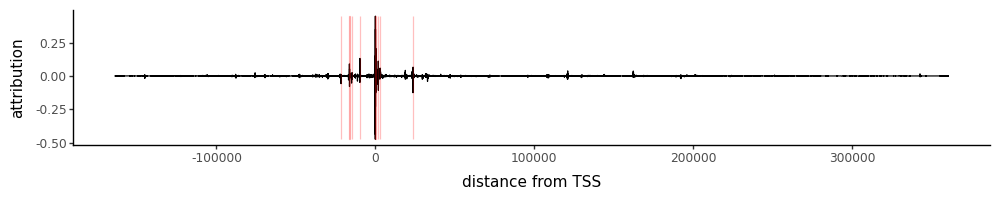

In [7]:
from IPython.display import Image

Image("output_classical_monoctypes/peaks_plots/SPI1.png")

In [8]:
! head output_classical_monoctypes/motifs.tsv | column -t -s $'\t' 

motif                  peak         start   end     strand  score               p-value                 matched_seq          site_attr_score  motif_attr_score       from_tss
GATA1.H12CORE.0.P.B    SPI1@-21642  142185  142203  +       17.218718886375427  1.4483521226793514e-07  CTGCCGGAGCAGATAAGG   -0.01716087      -0.05388813484491159   -21655
GATA2.H12CORE.1.P.B    SPI1@-21642  142185  142203  +       15.693981051445007  3.940949682146314e-07   CTGCCGGAGCAGATAAGG   -0.01716087      -0.05254237004625681   -21655
ZN468.H12CORE.0.P.C    SPI1@60      163899  163912  +       17.930082082748413  6.705522537231425e-07   AAGGGAGGGGGCT        -4.4164033e-05   -0.011190414708394268  59
ZN468.H12CORE.0.P.C    SPI1@67      163900  163913  +       17.930082082748413  6.705522537231425e-07   AAGGGAGGGGGCT        -4.4164033e-05   -0.011190414708394268  60
GATA1.H12CORE.1.PSM.A  SPI1@-21642  142193  142203  +       14.26537561416626   9.5367431640625e-07     GCAGATAAGG           -0.024452996     -0.0

In [9]:
! tail output_classical_monoctypes/motifs.tsv | column -t -s $'\t' 

ELF1.H12CORE.0.PSM.A   BRD3@1300    165136  165149  -  6.526547312736511   0.0004981756210327138  CCAGTTCCCGTTT                   0.004973818    0.01639644004477408     1296
ELF1.H12CORE.0.PSM.A   BRD3@1308    165136  165149  -  6.526547312736511   0.0004981756210327138  CCAGTTCCCGTTT                   0.004973818    0.01639644004477408     1296
ELF1.H12CORE.0.PSM.A   BRD3@1293    165136  165149  -  6.526547312736511   0.0004981756210327138  CCAGTTCCCGTTT                   0.004973818    0.01639644004477408     1296
EOMES.H12CORE.0.PSM.A  BRD3@-54477  109366  109377  -  7.6270527839660645  0.0004982948303222651  TATTACACTTT                     -0.0018187161  -0.0032079393545659416  -54474
ATOH8.H12CORE.0.P.C    BRD3@28499   192333  192344  +  7.900963187217712   0.0004982948303222656  CCGGCAGGTGG                     0.0031021938   0.007352716857984439    28493
HNF1A.H12CORE.0.PS.A   BRD3@-54610  109219  109234  -  5.932196259498596   0.0004984354600310315  TGTGATTCAGTGACA              

QC file (`qc.warnings.log`) is a quality control log file that contains warnings about prediction reliability for genes. Specifically, it warns when a gene has low correlation with the model's predictions (Pearson correlation < 0.7).

In [2]:
! cat output_classical_monoctypes/qc.warnings.log

Gene BRD3 has low correlation with the model. Pearson: 0.3452574205038928. Be careful with the predictions of the model for this gene.

### Querying Cells

To obtain attributions, cells of interest must be selected using the query API. We support Pandas' query API functionality on the cell metadata DataFrame. Here are examples of how to write queries:

In [11]:
! decima query-cell --help

Usage: decima query-cell [OPTIONS] [QUERY]

  Query a cell using query strig

  Examples:

      >>> decima query-cell 'cell_type == "classical monocyte"'     ...

      >>> decima query-cell 'cell_type == "classical monocyte" and disease ==
      "healthy" and tissue == "blood"'     ...

      >>> decima query-cell 'cell_type.str.contains("monocyte") and disease ==
      "healthy"'     ...

Options:
  --help  Show this message and exit.


Query cells of type "classical monocyte" using Pandas query syntax: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html

In [12]:
! decima query-cell 'cell_type == "classical monocyte"' | column -t -s $'\t'

wandb: Currently logged in as: celikm5 (celikm5-genentech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1277.4MB/s)
          cell_type           tissue                            organ           disease                                         study                                 dataset      region  subregion  celltype_coarse  n_cells  total_counts        n_genes  size_factor         train_pearson       val_pearson         test_pearson
agg_4705  classical monocyte  alveolar system                   lung            COVID-19                                        GSE155249                             scimilarity  nan     nan                         7244     26544273.0          15325    34749.092791034054  0.947042128504772   0.8433033438826081  0.8523116971050453
agg_4706  classical monocyte  alveolar system                   lung  

Query cells that:
- have "monocyte" in their cell type name (cell_type.str.contains("monocyte"))
- are from healthy donors (disease == "healthy")

In [13]:
! decima query-cell 'cell_type.str.contains("monocyte") and disease == "healthy"' | column -t -s $'\t'

wandb: Currently logged in as: celikm5 (celikm5-genentech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1181.5MB/s)
          cell_type               tissue                            organ           disease  study                                 dataset      region  subregion  celltype_coarse  n_cells  total_counts  n_genes  size_factor         train_pearson       val_pearson         test_pearson
agg_4706  classical monocyte      alveolar system                   lung            healthy  GSE155249                             scimilarity  nan     nan                         72       218105.0      9142     30484.31888978114   0.9100755400148017  0.807840111985257   0.8084927325394055
agg_4707  classical monocyte      ampulla of uterine tube           fallopian tube  healthy  fc77d2ae-247d-44d7-aa24-3f4859254c2c  scimilarity  nan     

This query selects cells that are:
- classical monocytes (cell_type == "classical monocyte")
- from healthy donors (disease == "healthy")
- from blood tissue (tissue == "blood")

In [14]:
! decima query-cell 'cell_type == "classical monocyte" and disease == "healthy" and tissue == "blood"' | column -t -s $'\t'

wandb: Currently logged in as: celikm5 (celikm5-genentech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1229.9MB/s)
          cell_type           tissue  organ  disease  study                                 dataset      region  subregion  celltype_coarse  n_cells  total_counts  n_genes  size_factor         train_pearson       val_pearson         test_pearson
agg_4733  classical monocyte  blood   blood  healthy  03f821b4-87be-4ff4-b65a-b5fc00061da7  scimilarity  nan     nan                         32464    109280914.0   16158    33646.02843110038   0.9571003409265929  0.853793540941388   0.850146121215848
agg_4734  classical monocyte  blood   blood  healthy  436154da-bcf1-4130-9c8b-120ff9a888f2  scimilarity  nan     nan                         76800    206490628.0   16683    30736.453324546856  0.9553395941624905  0.8482019468448739

### Attribution calling with custom genes and sequences

In [15]:
! cat ../tests/data/seqs.fasta | cut -c 1-200

>CD68|gene_mask_start=163840|gene_mask_end=166460
CTCTGCAGAGAGCGAGGACGGTGTGTCTGCCAGCGCCTTTGACTTCACTGTCTCCAACTTTGTGGACAACCTGTATGGCTACCCGGAAGGCAAGGATGTGCTTCGGGAGACCATCAAGTTTATGTACACAGACTGGGCCGACCGGGACAATGGCGAAATGCGCCGCAAAACCCTGCTGGCGCTCTTTACTGACCACCAAT
>SPI1|gene_mask_start=163840|gene_mask_end=187556
TGCCACTTTTAGATATGTTCATGGGTGCAGATACGGCTTTATTTATTTGAGACAGAGTTTCACTCTTGTTGCCCAGGGTGGAGTGCAGTGGTGCGATCTCAGCTCACTGCAGCCTTCGCCTCCCGGGTTGAAGCGATTCTTCTGCCTCAACCTCGAGTAGCTGGGATTATAGGCACCTGCCAGCATGCCTGGCTAATTTT


In [16]:
! decima attributions --seqs ../tests/data/seqs.fasta --tasks "cell_type == 'classical monocyte'" --output_dir output_custom_seqs/

decima.interpret.save_attributions - INFO - Using device: cuda
decima.interpret.save_attributions - INFO - Loading model and metadata to compute attributions...
wandb: Currently logged in as: celikm5 (celikm5-genentech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1227.2MB/s)
wandb: Downloading large artifact decima_rep0:latest, 2155.88MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.2 (1807.5MB/s)
wandb: Downloading large artifact human_state_dict_fold0:latest, 709.30MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1380.2MB/s)
Computing attributions...: 0it [00:00, ?it/s]wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1271.1MB/s)
/home/celikm5/miniforge3/envs/decima/lib/python3.11/site-packages/captum/_utils/gradient.

The output file for custom sequence also contains additional file of `seqs.fasta` which contains custom seqs. To visualize prediction on IGV, first load this fasta file and its index (.fai) to IGV, then load bam and bed files.

In [17]:
! ls output_custom_seqs/

attributions.h5  motifs.tsv  peaks_plots  seqs.fasta.fai
coverage	 peaks.bed   seqs.fasta


## Python User API


Let's look at a simple example using Decima's Python API to analyze the SPI1 gene, which is a key transcription factor in myeloid cell development. We'll examine its regulation across different monocyte and macrophage cell types where it is known to be important.

First we choice the cells, we are interested in:


In [18]:
import torch
from decima import predict_save_attributions


device = "cuda" if torch.cuda.is_available() else "cpu"

%matplotlib inline

In [19]:
spi1_cell_types = [
    "classical monocyte",
    "intermediate monocyte",
    "non-classical monocyte",
    "alveolar macrophage",
    "macrophage",
]

In [20]:
predict_save_attributions(
    output_dir="attrs_SP1I_monoctypes",
    genes=["SPI1"],
    tasks=f"cell_type in {spi1_cell_types}",
    device=device,
)

wandb: Currently logged in as: celikm5 (celikm5-genentech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1251.1MB/s)
wandb: Downloading large artifact decima_rep0:latest, 2155.88MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.3 (1710.0MB/s)
wandb: Downloading large artifact human_state_dict_fold0:latest, 709.30MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1363.8MB/s)
Saving coverage...: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


### Custom Sequences

Attributions for a custom sequence can be calculated by passing data frame with columns of `seq`, `gene_mask_start`, `gene_mask_end`. The index of the DataFrame will be used as gene names. 

In [21]:
import pandas as pd

df_seqs = pd.read_csv("../tests/data/seqs.csv", index_col=0)
df_seqs

,seq,gene_mask_start,gene_mask_end
name,,,
CD68,CTCTGCAGAGAGCGAGGACGGTGTGTCTGCCAGCGCCTTTGACTTC...,163840,166460
SPI1,TGCCACTTTTAGATATGTTCATGGGTGCAGATACGGCTTTATTTAT...,163840,187556


In [22]:
predict_save_attributions(
    output_dir="attrs_custom_seqs_monoctypes",
    seqs=df_seqs,  # <-- custom sequences
    tasks=f"cell_type in {spi1_cell_types}",
    device=device,
)
! ls attrs_custom_seqs_monoctypes

wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1262.7MB/s)
wandb: Downloading large artifact decima_rep0:latest, 2155.88MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.2 (1802.9MB/s)
wandb: Downloading large artifact human_state_dict_fold0:latest, 709.30MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1431.8MB/s)
Computing attributions...: 0it [00:00, ?it/s]wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1215.4MB/s)
/home/celikm5/miniforge3/envs/decima/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
Computing attributions...: 1it [00:02,  2.73s/it]wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.

attributions.h5  motifs.tsv  peaks_plots  seqs.fasta.fai
coverage	 peaks.bed   seqs.fasta


In [23]:
import torch
from grelu.sequence.format import strings_to_one_hot
from decima.constants import DECIMA_CONTEXT_SIZE

DECIMA_CONTEXT_SIZE

524288

In [24]:
seqs = torch.cat(
    [
        strings_to_one_hot(["A" * DECIMA_CONTEXT_SIZE]),  # one-hot encoded sequence
        torch.ones(1, 1, DECIMA_CONTEXT_SIZE),  # binary mask for the gene
    ],
    dim=1,
)
seqs.shape

torch.Size([1, 5, 524288])

In [25]:
predict_save_attributions(
    output_dir="attrs_custom_tensors_monoctypes",
    seqs=seqs,  # <-- custom sequences as torch.Tensor where (batch_size, 5, seq_len), second dimension is one-hot encoded sequence and binary mask for the gene
    tasks=f"cell_type in {spi1_cell_types}",
    device=device,
)
! ls attrs_custom_seqs_monoctypes

wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1252.2MB/s)
wandb: Downloading large artifact decima_rep0:latest, 2155.88MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.2 (1861.9MB/s)
wandb: Downloading large artifact human_state_dict_fold0:latest, 709.30MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1362.1MB/s)
Computing attributions...: 0it [00:00, ?it/s]wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1284.7MB/s)
/home/celikm5/miniforge3/envs/decima/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
Computing attributions...: 1it [00:02,  2.07s/it]
Saving sequences...: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

attributions.h5  motifs.tsv  peaks_plots  seqs.fasta.fai
coverage	 peaks.bed   seqs.fasta


### Advance Developer API

`DecimaResult` provides a unified interface for working with Decima results in anndata format. It contains an AnnData structure storing cell x gene expression data and metadata. Through DecimaResult, users can load pre-trained models, compute attributions to  understand genomic regulation, and analyze results through visualizations or export to genomic file formats. The object provides convenient access to cell and gene annotations through its metadata properties.

In [26]:
from decima.core import DecimaResult

result = DecimaResult.load()

wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1200.1MB/s)


In [27]:
result.cell_metadata.query("cell_type.str.endswith('macrophage')")

,cell_type,tissue,organ,disease,study,dataset,region,subregion,celltype_coarse,n_cells,total_counts,n_genes,size_factor,train_pearson,val_pearson,test_pearson
agg_4063,alveolar macrophage,alveolar system,lung,COVID-19,GSE155249,scimilarity,nan,nan,NaN,1453,8.001524e+06,14711,36293.472025,0.943437,0.836113,0.849484
agg_4064,alveolar macrophage,alveolar system,lung,healthy,GSE155249,scimilarity,nan,nan,NaN,1279,7.598244e+06,13673,34158.514496,0.933574,0.830062,0.843927
agg_4065,alveolar macrophage,left lung,lung,NA,ENCODE,scimilarity,nan,nan,NaN,405,3.000961e+06,16595,46501.375857,0.936345,0.847391,0.844917
agg_4066,alveolar macrophage,lingula of left lung,lung,healthy,a3ffde6c-7ad2-498a-903c-d58e732f7470,scimilarity,nan,nan,NaN,854,1.713753e+06,15110,42773.009735,0.894241,0.805377,0.803527
agg_4067,alveolar macrophage,lower lobe of left lung,lung,NA,ENCODE,scimilarity,nan,nan,NaN,763,1.344798e+07,17973,49020.804487,0.940693,0.854182,0.862222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
agg_6644,macrophage,uterus,uterus,healthy,32f2fd23-ec74-486f-9544-e5b2f41725f5,scimilarity,nan,nan,NaN,425,4.340830e+06,15233,36624.136739,0.955201,0.849213,0.842904
agg_6645,macrophage,uterus,uterus,healthy,e5f58829-1a66-40b5-a624-9046778e74f5,scimilarity,nan,nan,NaN,231,3.007554e+07,14787,27615.762157,0.840030,0.730177,0.719485
agg_6646,macrophage,vasculature,vasculature,healthy,e5f58829-1a66-40b5-a624-9046778e74f5,scimilarity,nan,nan,NaN,12497,4.040685e+08,18199,36829.498964,0.939161,0.836154,0.833769
agg_6647,macrophage,visceral fat,adipose,obesity,GSE128518,scimilarity,nan,nan,NaN,729,2.078431e+06,13760,34188.716187,0.941866,0.827007,0.823310


The results and metadata stored in anndata format which you can access directly if needed but most operation are supported by DecimaResult object.

In [28]:
result.anndata

AnnData object with n_obs × n_vars = 8856 × 18457
    obs: 'cell_type', 'tissue', 'organ', 'disease', 'study', 'dataset', 'region', 'subregion', 'celltype_coarse', 'n_cells', 'total_counts', 'n_genes', 'size_factor', 'train_pearson', 'val_pearson', 'test_pearson'
    var: 'chrom', 'start', 'end', 'strand', 'gene_type', 'frac_nan', 'mean_counts', 'n_tracks', 'gene_start', 'gene_end', 'gene_length', 'gene_mask_start', 'gene_mask_end', 'frac_N', 'fold', 'dataset', 'gene_id', 'pearson', 'size_factor_pearson'
    uns: 'log1p'
    layers: 'preds'

These are the cell metadata contained in the Decima object.

In [29]:
result.cell_metadata

,cell_type,tissue,organ,disease,study,dataset,region,subregion,celltype_coarse,n_cells,total_counts,n_genes,size_factor,train_pearson,val_pearson,test_pearson
agg_0,Amygdala excitatory,Amygdala_Amygdala,CNS,healthy,jhpce#tran2021,brain_atlas,Amygdala,Amygdala,NaN,331,1.592883e+07,17000,41431.465186,0.942474,0.841879,0.865579
agg_1,Amygdala excitatory,Amygdala_Basolateral nuclear group (BLN) - lat...,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Basolateral nuclear group (BLN) - lateral nucl...,NaN,11369,2.952133e+08,18080,40765.341481,0.943247,0.839565,0.860787
agg_2,Amygdala excitatory,Amygdala_Bed nucleus of stria terminalis and n...,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Bed nucleus of stria terminalis and nearby - BNST,NaN,139,2.593231e+06,15418,42556.387020,0.952271,0.855175,0.866643
agg_3,Amygdala excitatory,Amygdala_Central nuclear group - CEN,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Central nuclear group - CEN,NaN,3892,9.946371e+07,17959,42884.641430,0.959857,0.863817,0.881534
agg_4,Amygdala excitatory,Amygdala_Corticomedial nuclear group (CMN) - a...,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Corticomedial nuclear group (CMN) - anterior c...,NaN,2945,1.281619e+08,17885,41816.741933,0.951541,0.855172,0.868277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
agg_9533,vascular associated smooth muscle cell,upper lobe of right lung,lung,NA,ENCODE,scimilarity,nan,nan,NaN,21,3.483375e+04,8515,35404.911768,0.736001,0.664692,0.655120
agg_9535,vascular associated smooth muscle cell,urinary bladder,urinary,healthy,GSE129845,scimilarity,nan,nan,NaN,24,8.498500e+04,7337,26189.415789,0.810245,0.690370,0.656580
agg_9536,vascular associated smooth muscle cell,uterus,uterus,NA,ENCODE,scimilarity,nan,nan,NaN,272,5.700762e+05,14769,44938.403867,0.915162,0.807299,0.841429
agg_9537,vascular associated smooth muscle cell,uterus,uterus,healthy,e5f58829-1a66-40b5-a624-9046778e74f5,scimilarity,nan,nan,NaN,472,1.089170e+07,14514,30145.422152,0.852446,0.717448,0.729172


Similarly, these are the gene metadata contained in the Decima object.

In [30]:
result.gene_metadata

,chrom,start,end,strand,gene_type,frac_nan,mean_counts,n_tracks,gene_start,gene_end,gene_length,gene_mask_start,gene_mask_end,frac_N,fold,dataset,gene_id,pearson,size_factor_pearson
STRADA,chr17,63381538,63905826,-,protein_coding,0.000000,2.208074,7616,63682336,63741986,59650,163840,223490,0.000000,['fold1'],train,ENSG00000266173,0.492455,0.476627
ETV4,chr17,43219172,43743460,-,protein_coding,0.030873,0.925863,5004,43527844,43579620,51776,163840,215616,0.000000,['fold1'],train,ENSG00000175832,0.737548,0.613281
USP25,chr21,15566185,16090473,+,protein_coding,0.000000,3.650355,8604,15730025,15880069,150044,163840,313884,0.000000,['fold6'],train,ENSG00000155313,0.905298,0.784446
ZSWIM5,chr1,44945761,45470049,-,protein_coding,0.000620,2.190115,6123,45016399,45306209,289810,163840,453650,0.000000,['fold5'],train,ENSG00000162415,0.961775,0.795131
C21orf58,chr21,45963427,46487715,-,protein_coding,0.000791,1.650467,7354,46300181,46323875,23694,163840,187534,0.000000,['fold6'],train,ENSG00000160298,0.645260,0.412368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NPDC1,chr9,136685731,137210019,-,protein_coding,0.000000,2.625285,7852,137039463,137046179,6716,163840,170556,0.000000,['fold3'],test,ENSG00000107281,0.328081,0.178204
ZNF425,chr7,148765876,149290164,-,protein_coding,0.001048,1.292957,6511,149102784,149126324,23540,163840,187380,0.000000,['fold7'],train,ENSG00000204947,0.818260,0.737081
COL5A1,chr9,134477934,135002222,+,protein_coding,0.002159,1.492664,6209,134641774,134844843,203069,163840,366909,0.000000,['fold3'],test,ENSG00000130635,0.766627,0.456999
BRD3,chr9,133708087,134232375,-,protein_coding,0.000000,3.190450,8675,134030305,134068535,38230,163840,202070,0.004662,['fold3'],test,ENSG00000169925,0.345257,0.280283


You can also access the genes and cells:

In [31]:
result.genes

Index(['STRADA', 'ETV4', 'USP25', 'ZSWIM5', 'C21orf58', 'MIR497HG', 'CFAP74',
       'GSE1', 'LPP', 'CLK1',
       ...
       'STRIP2', 'TNFRSF1A', 'RBM14-RBM4', 'C1orf21', 'LINC00639', 'NPDC1',
       'ZNF425', 'COL5A1', 'BRD3', 'EVI5L'],
      dtype='object', length=18457)

Cell indexes can be also accessed:

In [32]:
result.cells

Index(['agg_0', 'agg_1', 'agg_2', 'agg_3', 'agg_4', 'agg_5', 'agg_6', 'agg_7',
       'agg_8', 'agg_9',
       ...
       'agg_9528', 'agg_9529', 'agg_9530', 'agg_9531', 'agg_9532', 'agg_9533',
       'agg_9535', 'agg_9536', 'agg_9537', 'agg_9538'],
      dtype='object', length=8856)

Predicted gene expression for specific gene can be accessed:

In [33]:
result.predicted_expression_matrix(genes=["SPI1"])

,SPI1
agg_0,0.235185
agg_1,0.206469
agg_2,0.152874
agg_3,0.206552
agg_4,0.208177
...,...
agg_9533,0.473107
agg_9535,0.268442
agg_9536,0.336398
agg_9537,0.137872


Or for all the genes:

In [34]:
result.predicted_expression_matrix()

,STRADA,ETV4,USP25,ZSWIM5,C21orf58,MIR497HG,CFAP74,GSE1,LPP,CLK1,...,STRIP2,TNFRSF1A,RBM14-RBM4,C1orf21,LINC00639,NPDC1,ZNF425,COL5A1,BRD3,EVI5L
agg_0,3.001925,1.762730,4.592772,5.099946,1.774805,0.356839,2.723968,4.739502,4.878714,3.327033,...,2.920594,0.297011,1.813074,4.493094,1.586075,3.319982,2.364579,2.374891,2.890716,3.253235
agg_1,3.003353,1.782654,4.723227,5.510479,1.666820,0.352753,2.425501,4.544352,4.855130,3.192972,...,3.227516,0.242533,1.818673,4.679863,1.348369,3.632192,2.463864,2.054537,2.700207,3.452777
agg_2,2.978871,2.089668,4.865537,5.617505,1.773259,0.380907,2.543027,4.512998,4.782970,3.390886,...,3.180318,0.263283,1.930930,4.540818,1.299774,4.154801,2.433835,2.297276,2.890761,3.629054
agg_3,3.074754,2.038535,4.884157,5.273578,1.760010,0.463595,2.543533,4.039080,4.854626,3.411034,...,2.939788,0.290311,1.847241,4.780760,1.529227,3.828480,2.331008,2.121762,2.608462,3.186322
agg_4,3.103840,1.959215,4.590865,5.256962,1.755244,0.382228,2.587021,4.453868,4.932796,3.250587,...,3.205086,0.258538,1.966316,4.641990,1.326930,3.780137,2.444831,2.255797,2.889546,3.451440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
agg_9533,2.289689,0.581705,4.639077,2.793091,0.751956,0.692147,0.568351,4.420611,6.842777,3.695646,...,0.549443,2.270267,1.523273,4.432419,0.614325,1.389469,1.054450,3.759573,2.514814,1.981362
agg_9535,0.833283,0.326443,1.960863,0.307475,0.337182,0.834267,0.110843,1.929069,3.701684,4.467318,...,0.178374,1.370960,1.084590,3.587358,0.068649,1.980652,0.240619,1.448074,1.673506,1.171897
agg_9536,3.036649,1.131592,4.749751,3.931905,1.401179,1.638554,1.078200,4.855861,6.520594,4.127848,...,1.195112,1.870594,2.443540,5.207511,1.023207,1.918750,2.230703,4.244238,2.968915,2.759851
agg_9537,1.264902,0.410833,2.903708,0.571702,0.486362,1.175724,0.165795,2.461262,4.814781,4.913913,...,0.373774,1.361205,1.722287,4.142306,0.095901,1.665432,0.493823,2.066999,2.361383,1.569963


In [35]:
result.load_model(device=device)

wandb: Downloading large artifact decima_rep0:latest, 2155.88MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.2 (1843.5MB/s)
wandb: Downloading large artifact human_state_dict_fold0:latest, 709.30MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1305.1MB/s)


DecimaResult(anndata=AnnData object with n_obs × n_vars = 8856 × 18457
    obs: 'cell_type', 'tissue', 'organ', 'disease', 'study', 'dataset', 'region', 'subregion', 'celltype_coarse', 'n_cells', 'total_counts', 'n_genes', 'size_factor', 'train_pearson', 'val_pearson', 'test_pearson'
    var: 'chrom', 'start', 'end', 'strand', 'gene_type', 'frac_nan', 'mean_counts', 'n_tracks', 'gene_start', 'gene_end', 'gene_length', 'gene_mask_start', 'gene_mask_end', 'frac_N', 'fold', 'dataset', 'gene_id', 'pearson', 'size_factor_pearson'
    uns: 'log1p'
    layers: 'preds')

Prepare an input for th SPI1 genes.


Takes around ~10 seconds on GPU and ~5 minutes to call attributions on CPU. 

In [36]:
attrs = result.attributions(
    gene="SPI1",
    tasks=result.query_cells(f"cell_type in {spi1_cell_types}"),
    off_tasks=result.query_cells(f'organ == "blood" and cell_type not in {spi1_cell_types}'),
)

/home/celikm5/miniforge3/envs/decima/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.


Attributions can be visualized and processed with attributions object:

In [37]:
attrs.peaks

,peak,start,end,attribution,p-value,from_tss
0,SPI1@36,163876,163900,12.244095,0.000033,36
1,SPI1@-64,163776,163784,-8.974611,0.000037,-64
2,SPI1@-86,163754,163762,-8.996740,0.000041,-86
3,SPI1@-16,163824,163834,-9.611740,0.000059,-16
4,SPI1@29,163869,163873,1.838594,0.000105,29
5,SPI1@-72,163768,163774,2.258713,0.000128,-72
6,SPI1@-37,163803,163808,-2.364218,0.000128,-37
7,SPI1@-55,163785,163801,8.993019,0.000138,-55
8,SPI1@268,164108,164115,2.726677,0.000140,268
9,SPI1@23,163863,163868,-1.509830,0.000150,23


In [38]:
attrs.peaks_to_bed()

,chrom,start,end,name,score,strand
0,chr11,47378516,47378540,SPI1@36,4,.
1,chr11,47378632,47378640,SPI1@-64,4,.
2,chr11,47378654,47378662,SPI1@-86,4,.
3,chr11,47378582,47378592,SPI1@-16,4,.
4,chr11,47378543,47378547,SPI1@29,3,.
5,chr11,47378642,47378648,SPI1@-72,3,.
6,chr11,47378608,47378613,SPI1@-37,3,.
7,chr11,47378615,47378631,SPI1@-55,3,.
8,chr11,47378301,47378308,SPI1@268,3,.
9,chr11,47378548,47378553,SPI1@23,3,.


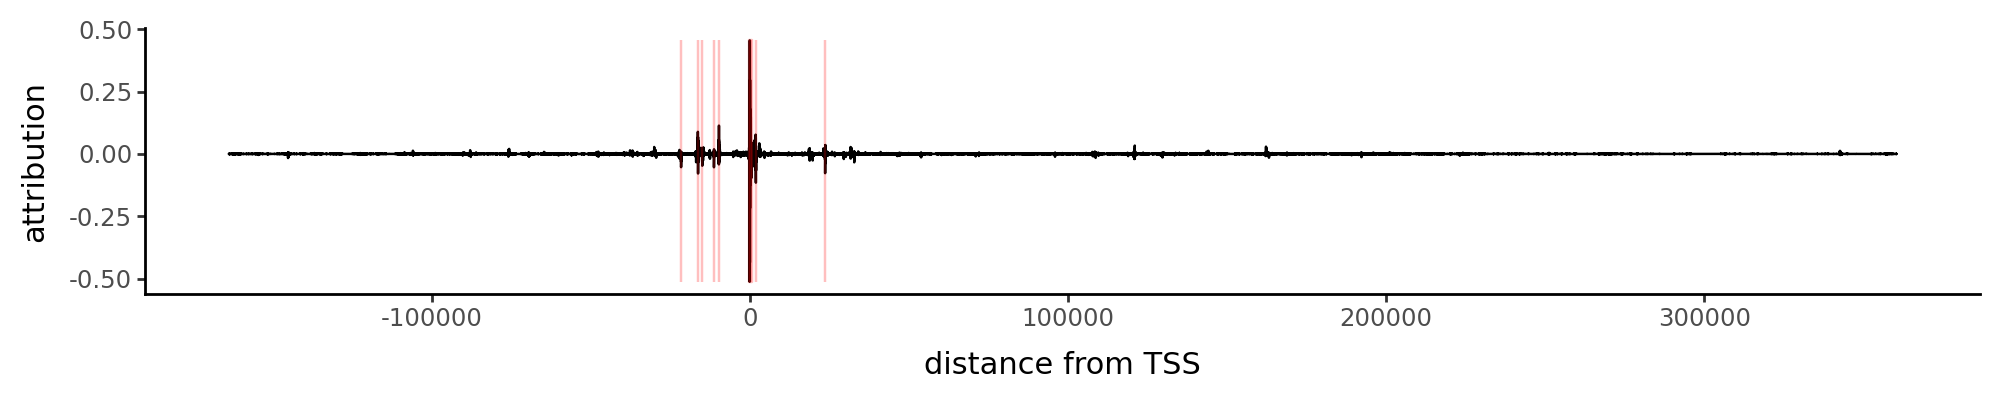

In [39]:
attrs.plot_peaks()

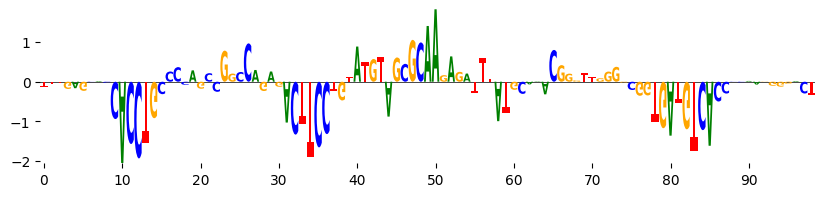

In [40]:
import matplotlib.pyplot as plt

attrs.plot_seqlogo(relative_loc=-45)
plt.show()

This comment takes around ~1 minutes and detects motifs in the attributions using FIMO. The motifs are ranked by their attribution scores:

In [41]:
df_motifs = attrs.scan_motifs()
df_motifs

,motif,peak,start,end,strand,score,p-value,matched_seq,site_attr_score,motif_attr_score,from_tss
1024,VEZF1.H12CORE.1.P.B,SPI1@1919,165743,165766,+,20.238946,2.193042e-08,GGGAGGAGGGAGGAAGGTGGGAG,-0.010757,-0.012639,1903
1286,GATA1.H12CORE.0.P.B,SPI1@-21642,142185,142203,+,17.218719,1.448352e-07,CTGCCGGAGCAGATAAGG,-0.015701,-0.049351,-21655
1029,VEZF1.H12CORE.1.P.B,SPI1@1919,165750,165773,+,17.781552,2.886199e-07,GGGAGGAAGGTGGGAGGAAAGAA,-0.015932,-0.025867,1910
1066,ZN263.H12CORE.1.P.B,SPI1@1919,165742,165763,+,18.541907,2.975323e-07,AGGGAGGAGGGAGGAAGGTGG,-0.010819,-0.015170,1902
1289,GATA2.H12CORE.1.P.B,SPI1@-21642,142185,142203,+,15.693981,3.940950e-07,CTGCCGGAGCAGATAAGG,-0.015701,-0.048095,-21655
...,...,...,...,...,...,...,...,...,...,...,...
483,TEAD3.H12CORE.0.PS.A,SPI1@60,163887,163900,-,7.540831,4.978180e-04,CCCTGCAATGTCA,0.105860,0.246162,47
1713,HNF4G.H12CORE.0.P.B,SPI1@-93,163738,163753,-,3.927308,4.979549e-04,AGCCCTTTGAGCACC,-0.019281,-0.025855,-102
97,HNF4G.H12CORE.0.P.B,SPI1@-86,163736,163751,-,3.927308,4.979549e-04,AGCCCTTTGAGCACC,-0.019281,-0.025855,-104
1832,ZNF30.H12CORE.0.P.C,SPI1@1840,165662,165685,+,7.201793,4.997881e-04,GGGCGGGGAGGCCTGATGACTGT,0.007895,0.010208,1822


If you just want attribution tensor from input one_hot encoded sequence prepare your input and call attributions object:

In [42]:
one_hot_seq, gene_mask = result.prepare_one_hot("SPI1")
inputs = torch.vstack([one_hot_seq, gene_mask]).unsqueeze(0)
inputs.shape  # (batch_size, 5, seq_len)

torch.Size([1, 5, 524288])

In [43]:
from decima.interpret.attributions import attributions

attrs = attributions(
    inputs=inputs,
    model=result.model,
    tasks=result.query_cells(f"cell_type in {spi1_cell_types}"),
    off_tasks=result.query_cells(f'organ == "blood" and cell_type not in {spi1_cell_types}'),
)
attrs  # (batch_size, 4, seq_len) gene mask is removed from final attributions

/home/celikm5/miniforge3/envs/decima/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.


array([[[-0.0000000e+00,  0.0000000e+00, -0.0000000e+00, ...,
         -0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-0.0000000e+00, -0.0000000e+00, -2.7136472e-05, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-0.0000000e+00,  1.2634220e-04,  0.0000000e+00, ...,
          3.7220303e-05, -0.0000000e+00,  1.5047322e-05],
        [ 1.7313290e-04, -0.0000000e+00,  0.0000000e+00, ...,
         -0.0000000e+00,  1.2202940e-05, -0.0000000e+00]]], dtype=float32)